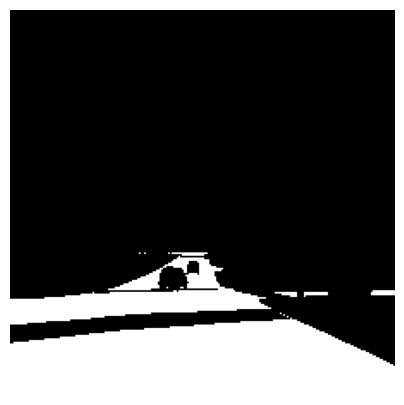

In [5]:
show(trn_ds[1][1])

In [1]:
import pytorch_lightning as pl
from model.model import SegModel
import torch
from nets.U_net_simple import UNet
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

from torch.utils.data import DataLoader 
from dataset.dataset import SegData

/home/user/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/user/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
net = UNet()
model = SegModel(image_path = '../seg_dataset/images', mask_path = '../seg_dataset/maps_roads',
                 train_ratio = 0.9, num_workers = 8, batch_size = 16, net = net)

/home/user/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
checkpoint_callback = ModelCheckpoint(dirpath=r'checkpoints', save_top_k = 3, monitor="Loss_valid", filename="check-{epoch:02d}-{Loss_valid:.2f}-{Accuracy_valid:.2f}")
logger = CSVLogger(r"logs/UNet_simple", name='simple_UNet', flush_logs_every_n_steps = 5)
trainer = pl.Trainer(accelerator = 'cuda', max_epochs=1,  callbacks=[checkpoint_callback], logger = logger, strategy='ddp_notebook',
                     enable_progress_bar = True,  log_every_n_steps = 100, devices=[0], # limit_train_batches=3, limit_val_batches=3,
                     deterministic=False, default_root_dir = r'logs/UNet_simple')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [7]:
import torch
torch.__version__

'2.4.1+cu124'

In [8]:
torch.multiprocessing.set_start_method('spawn')

In [9]:
trainer.fit(model)

ProcessRaisedException: 

-- Process 0 terminated with the following error:
Traceback (most recent call last):
  File "/home/user/.local/lib/python3.8/site-packages/torch/multiprocessing/spawn.py", line 76, in _wrap
    fn(i, *args)
  File "/home/user/.local/lib/python3.8/site-packages/pytorch_lightning/strategies/launchers/multiprocessing.py", line 173, in _wrapping_function
    results = function(*args, **kwargs)
  File "/home/user/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py", line 574, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "/home/user/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py", line 937, in _run
    self.strategy.setup_environment()
  File "/home/user/.local/lib/python3.8/site-packages/pytorch_lightning/strategies/ddp.py", line 153, in setup_environment
    super().setup_environment()
  File "/home/user/.local/lib/python3.8/site-packages/pytorch_lightning/strategies/strategy.py", line 128, in setup_environment
    self.accelerator.setup_device(self.root_device)
  File "/home/user/.local/lib/python3.8/site-packages/pytorch_lightning/accelerators/cuda.py", line 46, in setup_device
    _check_cuda_matmul_precision(device)
  File "/home/user/.local/lib/python3.8/site-packages/lightning_fabric/accelerators/cuda.py", line 161, in _check_cuda_matmul_precision
    if not torch.cuda.is_available() or not _is_ampere_or_later(device):
  File "/home/user/.local/lib/python3.8/site-packages/lightning_fabric/accelerators/cuda.py", line 155, in _is_ampere_or_later
    major, _ = torch.cuda.get_device_capability(device)
  File "/home/user/.local/lib/python3.8/site-packages/torch/cuda/__init__.py", line 451, in get_device_capability
    prop = get_device_properties(device)
  File "/home/user/.local/lib/python3.8/site-packages/torch/cuda/__init__.py", line 465, in get_device_properties
    _lazy_init()  # will define _get_device_properties
  File "/home/user/.local/lib/python3.8/site-packages/torch/cuda/__init__.py", line 314, in _lazy_init
    torch._C._cuda_init()
RuntimeError: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 802: system not yet initialized


In [27]:
torch.save(net.state_dict(), 'simple_unet.pth')

In [26]:
import numpy as np
import torch

In [29]:
val_ds = SegData(image_path = '../seg_dataset/images', mask_path = '../seg_dataset/maps_roads',
                 train_ratio = 0.9,  mode = 'train', seed = 1)
batch = next(iter(val_ds))
img, mask = batch 

In [30]:
batched_img = np.expand_dims(np.transpose(img, (2, 0, 1)), axis=0)
batched_mask = np.expand_dims(mask, axis=0)

In [7]:
model = SegModel.load_from_checkpoint('checkpoints/check-epoch=00-Loss_valid=0.12-Accuracy_valid=0.95.ckpt')

RuntimeError: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 802: system not yet initialized

In [12]:
net.load_state_dict(torch.load('simple_unet.pth'))

/tmp/ipykernel_1940344/3903000480.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('simple_unet.pth'))


RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

In [8]:
net.eval()
#in_img = 
pred = model.forward(torch.tensor(batched_img, dtype = torch.float32))

NameError: name 'net' is not defined

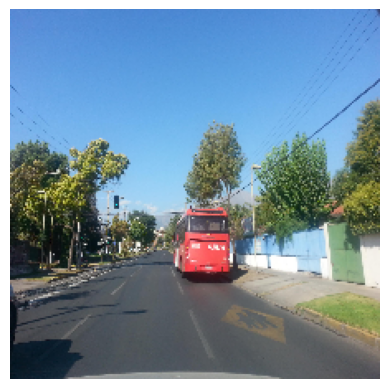

In [46]:
import matplotlib.pyplot as plt
# Визуализация массива
plt.imshow(img, cmap='binary')
plt.axis('off')
plt.show()

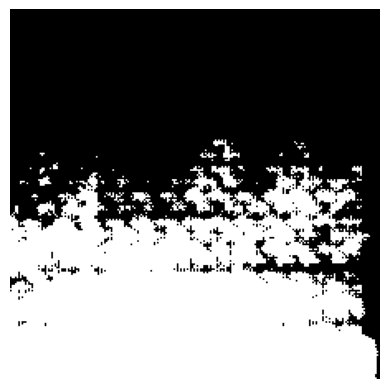

In [50]:
# Замена чисел больше 0.5 на 1, остальные на 0
pred[pred > 0.5] = 1
pred[pred <= 0.5] = 0

# Визуализация массива
plt.imshow(pred.squeeze(0)[0].detach().numpy(), cmap='gray')
plt.axis('off')
plt.show()

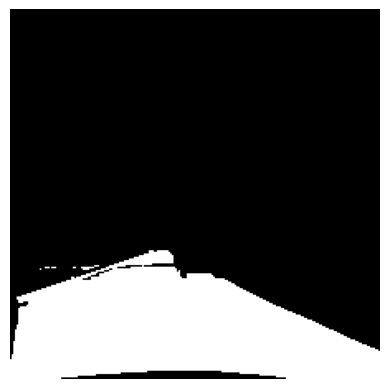

In [47]:
# Визуализация массива
plt.imshow(batched_mask[0], cmap='gray')
plt.axis('off')
plt.show()